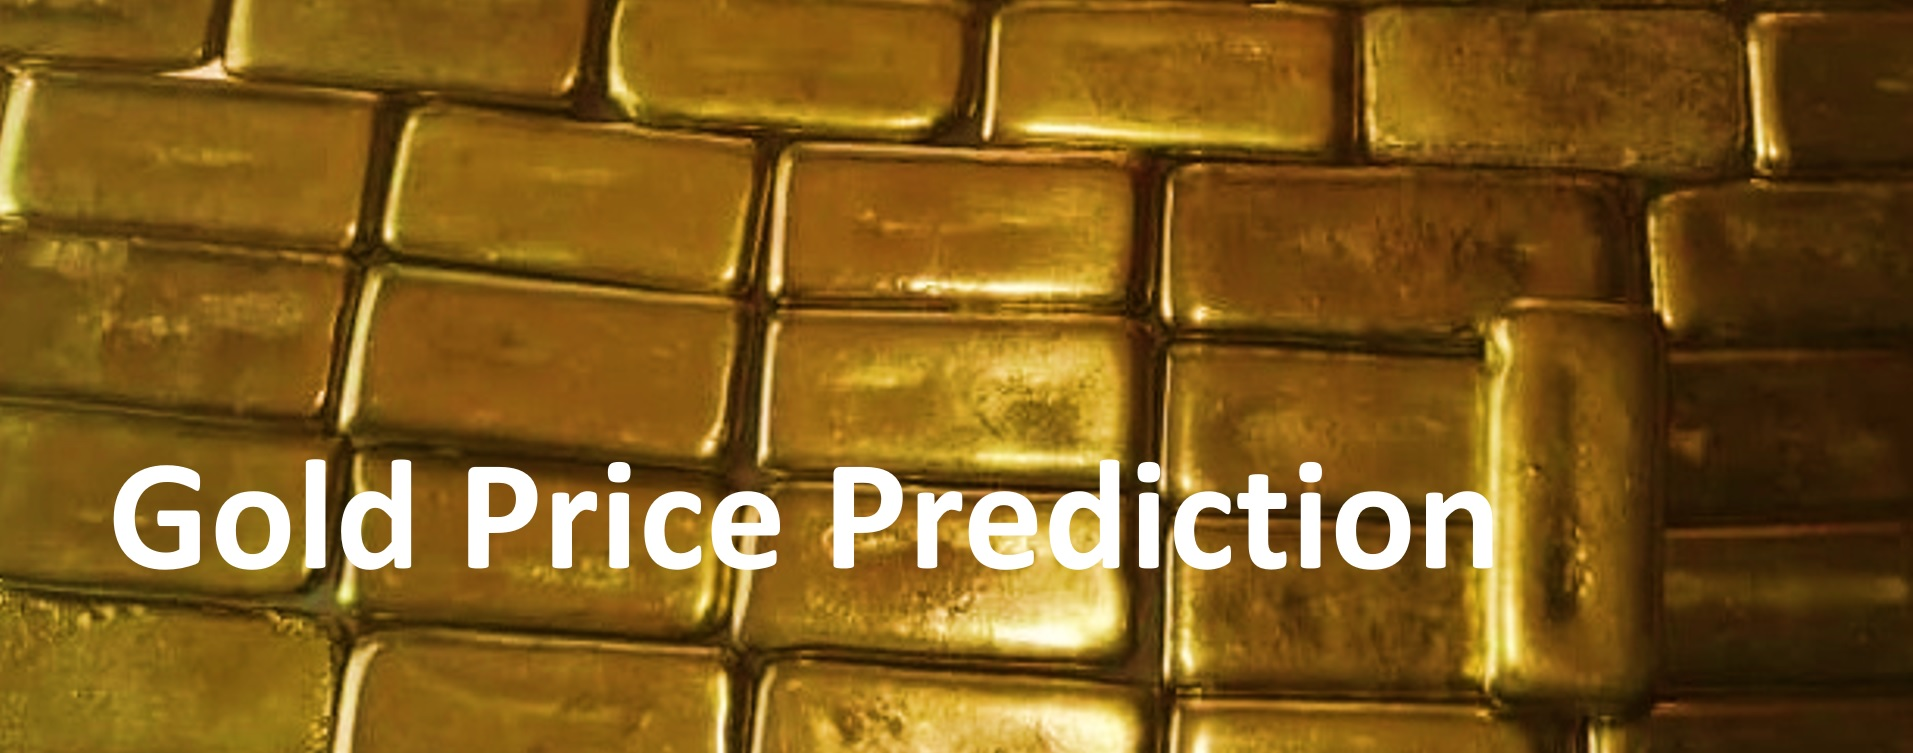

__In this notebook, we are going to build a time series model to predict the future price of gold, which can be very useful for traders. For this purpose, we use the historical gold price data for 10 years (from 2013 to 2023).__

### Let's get started:

# Step 1: Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM

# Step 2: Reading Dataset

In [2]:
import os
import pandas as pd

# Check available datasets
print("Available datasets:")
for file in os.listdir('dataset'):
    print(file)

# Load the gold prices dataset
df = pd.read_csv('dataset/gold prices.csv')

Available datasets:
Gold Futures Historical Data (23.01.24-22.11.24).csv
Gold prices (18.08.2023 - 22.01.2024).xlsx
gold prices.csv
Silver Futures Historical Data (23.01.24-22.11.24).csv
Silver prices (18.08.2023 - 22.01.2024).xlsx
silver prices.csv


# Step 3: Dataset Overview

In [3]:
df

,Date,Close/Last,Volume,Open,High,Low
0,08/17/2023,1915.2,146770.0,1922.4,1933.5,1914.2
1,08/16/2023,1928.3,124766.0,1933.1,1938.2,1922.0
2,08/15/2023,1935.2,161512.0,1939.4,1944.3,1927.5
3,08/14/2023,1944.0,117514.0,1945.6,1948.2,1934.2
4,08/11/2023,1946.6,119090.0,1944.9,1953.6,1942.7
...,...,...,...,...,...,...
2534,08/23/2013,1395.8,149116.0,1376.1,1399.9,1367.8
2535,08/22/2013,1370.8,134493.0,1365.6,1381.4,1354.5
2536,08/21/2013,1370.1,137350.0,1371.0,1378.9,1359.2
2537,08/20/2013,1372.6,130096.0,1364.9,1378.0,1351.6


__As you can see, the data set includes daily gold price information including daily Open, High and Low prices and the final price of each day (Price) along with the volume of transactions and price changes in each day.__

__Dataset Basic Information:__

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2539 entries, 0 to 2538
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        2539 non-null   object 
 1   Close/Last  2539 non-null   float64
 2   Volume      2511 non-null   float64
 3   Open        2539 non-null   float64
 4   High        2539 non-null   float64
 5   Low         2539 non-null   float64
dtypes: float64(5), object(1)
memory usage: 119.1+ KB


__All variables are stored as object.__

# Step 4: Data Preparation

## Step 4.1: Feature Subset Selection
__Since we will not use Vol. and Change % features to predict Price, we will drop these two features:__

In [5]:
# Let's examine the columns first
print("Dataset columns:", df.columns.tolist())
print("Dataset shape:", df.shape)

# Keep only the necessary columns for price prediction
# We'll use Date, Open, High, Low, Close/Last for our analysis
# Drop Volume as it's not needed for price prediction
df = df.drop(['Volume'], axis=1)

# Rename Close/Last to Price for consistency with the notebook
df = df.rename(columns={'Close/Last': 'Price'})
print("Updated columns:", df.columns.tolist())

Dataset columns: ['Date', 'Close/Last', 'Volume', 'Open', 'High', 'Low']
Dataset shape: (2539, 6)
Updated columns: ['Date', 'Price', 'Open', 'High', 'Low']


## Step 4.2: Transforming Data

__Date feature is stored as object in the data frame. To increase the speed of calculations, we convert it's data type to datetime and then sort this feature in ascending order:__

In [6]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

__The " , " sign is redundant in the dataset. First, we remove it from the entire dataset and then change the data type of the numerical variables to float:__

In [7]:
NumCols = df.columns.drop(['Date'])
df[NumCols] = df[NumCols].replace({',': ''}, regex=True)
df[NumCols] = df[NumCols].astype('float64')

__Result:__

In [8]:
df.head()

,Date,Price,Open,High,Low
0,2013-08-19,1365.7,1377.1,1384.1,1362.0
1,2013-08-20,1372.6,1364.9,1378.0,1351.6
2,2013-08-21,1370.1,1371.0,1378.9,1359.2
3,2013-08-22,1370.8,1365.6,1381.4,1354.5
4,2013-08-23,1395.8,1376.1,1399.9,1367.8


## Step 4.3: Checking Duplicates
__There are no duplicate samples in Date feature:__

In [9]:
df.duplicated().sum()

0

## Step 4.4: Checking Missing Values
__There are no missing values in the dataset:__

In [10]:
df.isnull().sum().sum()

0

# Step 5: Visualizing Gold Price History Data

__Interactive Gold Price Chart:__

In [11]:
fig = px.line(y=df.Price, x=df.Date)
fig.update_traces(line_color='black') 
fig.update_layout(xaxis_title="Date", 
                  yaxis_title="Scaled Price",
                  title={'text': "Gold Price History Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(255,223,0,0.8)')

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'x=%{x}<br>y=%{y}<extra></extra>',
              'legendgroup': '',
              'line': {'color': 'black', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '',
              'showlegend': False,
              'type': 'scattergl',
              'x': array([datetime.datetime(2013, 8, 19, 0, 0),
                          datetime.datetime(2013, 8, 20, 0, 0),
                          datetime.datetime(2013, 8, 21, 0, 0), ...,
                          datetime.datetime(2023, 8, 15, 0, 0),
                          datetime.datetime(2023, 8, 16, 0, 0),
                          datetime.datetime(2023, 8, 17, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([1365.7, 1372.6, 1370.1, ..., 1935.2, 1928.3, 1915.2]),
              'yaxis': 'y'}],
    'layout': {'legend': {'tracegroupgap': 0},
               'margin': {'t': 60},
               'plot_bgcolor': 'rgba(255,223,0,0.8)',
               'template': '...',
               'title': {'text': 'Gold Price History Data', 'x': 0.5, 'xanchor': 'center', 'y': 0.95, 'yanchor': 'top'},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'Date'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'Scaled Price'}}}
})

# Step 6: Splitting Data to Training & Test Sets
__Since we cannot train on future data in time series data, we should not divide the time series data randomly. In time series splitting, testing set is always later than training set. We consider the last year for testing and everything else for training:__

In [12]:
# Check the date range in our dataset
print("Date range in dataset:")
print("From:", df['Date'].min())
print("To:", df['Date'].max())
print("Years available:", sorted(df['Date'].dt.year.unique()))

# Use the last 20% of data for testing (more flexible than fixed year)
test_size = int(len(df) * 0.2)
print(f"Total samples: {len(df)}")
print(f"Test samples: {test_size}")
print(f"Training samples: {len(df) - test_size}")

Date range in dataset:
From: 2013-08-19 00:00:00
To: 2023-08-17 00:00:00
Years available: [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
Total samples: 2539
Test samples: 507
Training samples: 2032


__Plot Gold Price Training and Test Sets:__

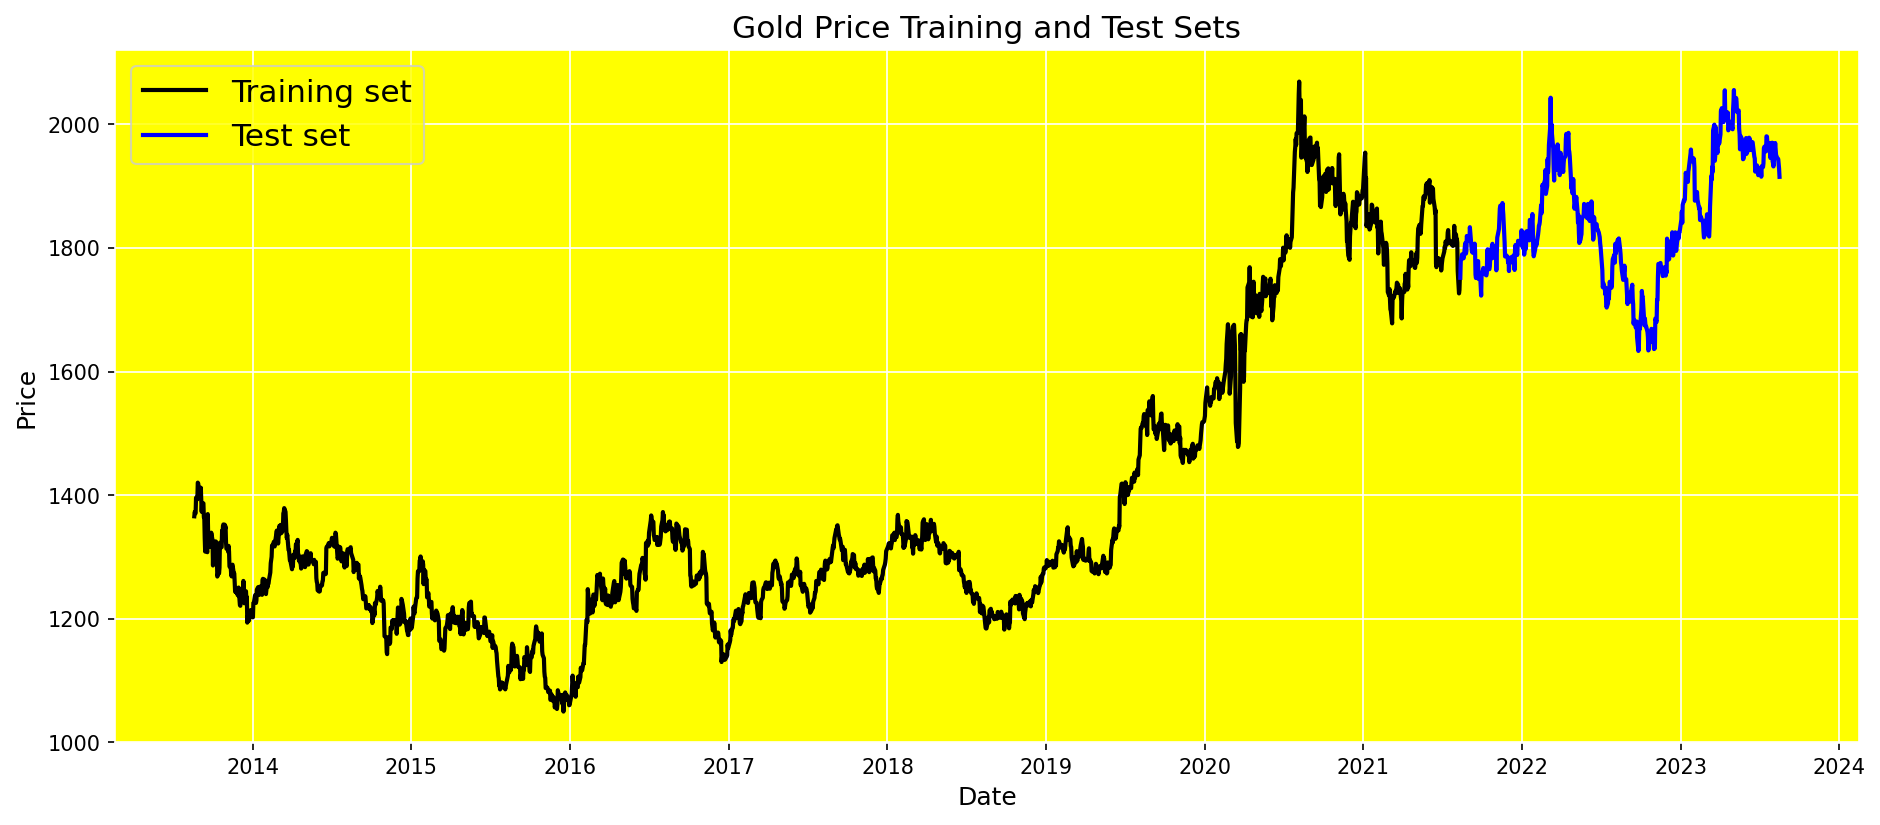

In [13]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df.Date[:-test_size], df.Price[:-test_size], color='black', lw=2)
plt.plot(df.Date[-test_size:], df.Price[-test_size:], color='blue', lw=2)
plt.title('Gold Price Training and Test Sets', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

# Step 7: Data Scaling
__Since we aim to predict Price only based on its historical data, we scale Price using MinMaxScaler to avoid intensive computations:__

In [14]:
scaler = MinMaxScaler()
scaler.fit(df.Price.values.reshape(-1,1))

MinMaxScaler()

# Step 8: Restructure Data & Create Sliding Window
__The use of prior time steps to predict the next time step is called sliding window. In this way, time series data can be expressed as supervised learning. We can do this by using previous time steps as input variables and use the next time step as the output variable. The number of previous time steps is called the window width. Here we set window width to 60. Therefore, X_train and X_test will be nested lists containing lists of 60 time-stamp prices. y_train and y_test are also lists of gold prices containing the next day's gold price corresponds to each list in X_train and X_test respectively:__

In [15]:
window_size = 60

__Training Set:__

In [16]:
train_data = df.Price[:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

In [17]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

__Test Set:__

In [18]:
test_data = df.Price[-test_size-60:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [19]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])

# Step 9: Converting Data to Numpy Arrays

__Now X_train and X_test are nested lists (two-dimensional lists) and y_train is a one-dimensional list. We need to convert them to numpy arrays with a higher dimension, which is the data format accepted by TensorFlow when training the neural network:__

In [20]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [21]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [22]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (1972, 60, 1)
y_train Shape:  (1972, 1)
X_test Shape:   (507, 60, 1)
y_test Shape:   (507, 1)


# Step 10: Creating an LSTM Network 
__We build an LSTM network, which is a type of Recurrent Neural Networks designed to solve vanishing gradient problem:__

__Model Definition:__

In [23]:
def define_model():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = 64, return_sequences=True)(input1)  
    x = Dropout(0.2)(x)
    x = LSTM(units = 64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()
    
    return model

__Model Training:__

In [24]:
model = define_model()
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.1, verbose=1)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,057 (332.25 KB)

 Trainable params: 85,057 (332.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 0.0525 - val_loss: 0.0977
Epoch 2/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 0.0525 - val_loss: 0.0977
Epoch 2/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0100 - val_loss: 0.0513
Epoch 3/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0100 - val_loss: 0.0513
Epoch 3/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.0054 - val_loss: 0.0294
Epoch 4/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.0054 - val_loss: 0.0294
Epoch 4/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0046 - val_loss: 0.0163
Epoch 5/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0046 - val_loss: 0.0163
Epoch 5/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0036 - val_loss: 0.0090
Epoch 6/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0036 - val_loss: 0.0090
Epoch 6/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0030 - val_loss: 0.0056
Epoch 7/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - 

# Step 11: Model Evaluation
__Next, we evaluate our time series forecast using MAPE (Mean Absolute Percentage Error) metric:__

In [25]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test) 

9/9 [==============================] - 1s 12ms/step


In [26]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE

In [27]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: 0.0009651753935031593
Test MAPE: 0.0345913820677349
Test Accuracy: 0.9654086179322651


# Step 12: Visualizing Results

__Returning the actual and predicted Price values to their primary scale:__

In [28]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

__Investigating the closeness of the prices predicted by the model to the real prices:__

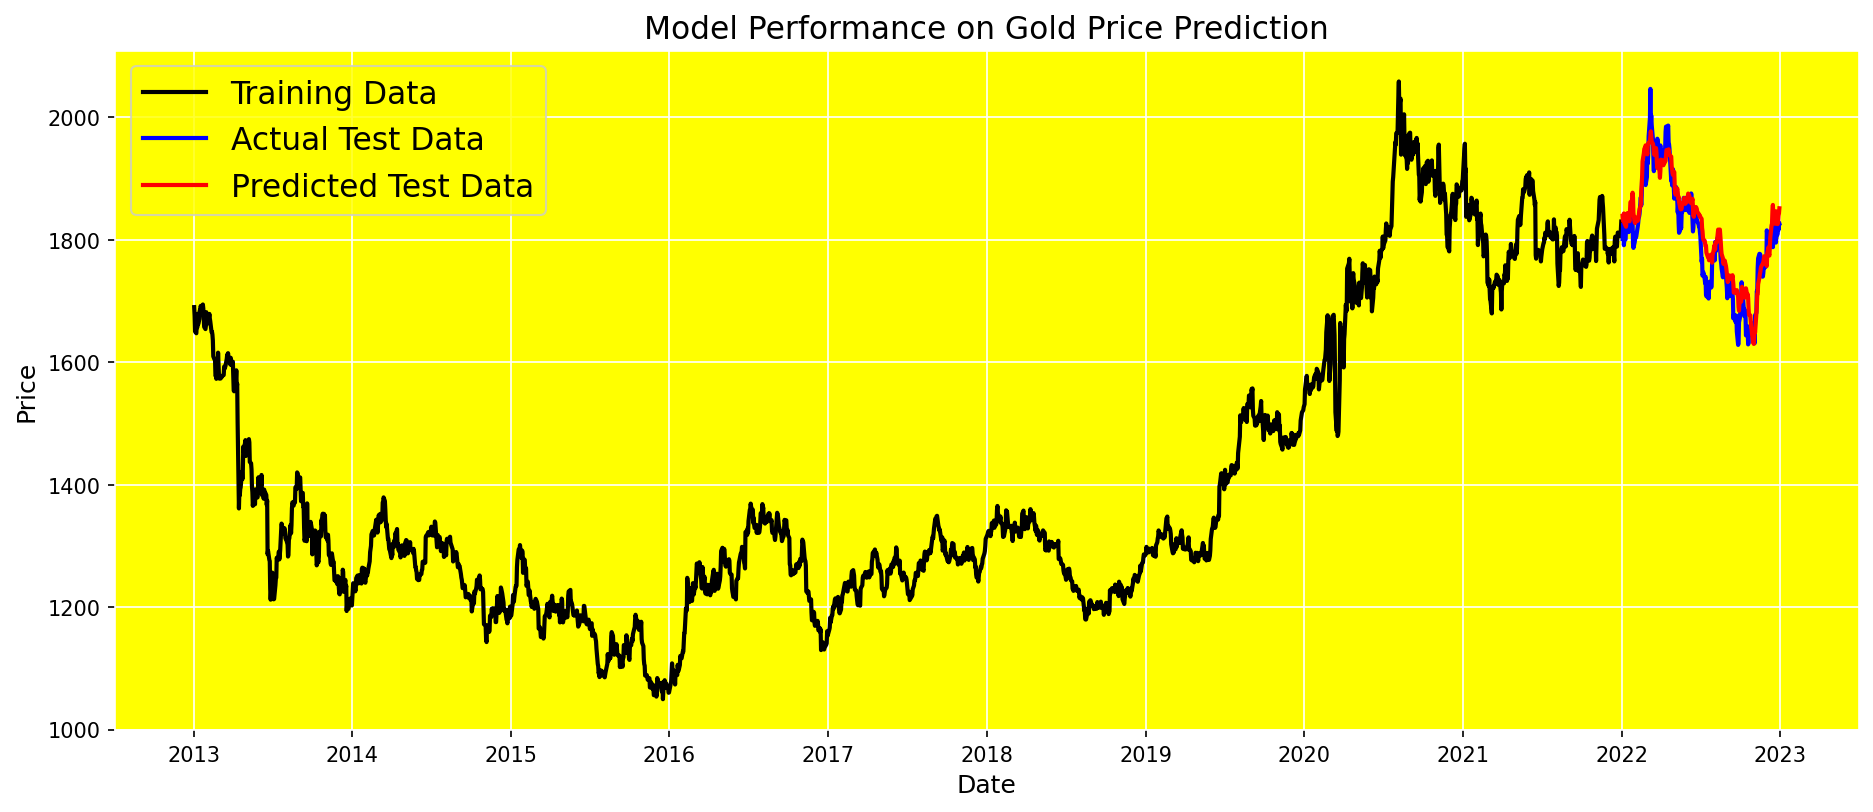

In [29]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Model Performance on Gold Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

____
# Conclusion:
### As can be seen, the price predicted by the LSTM model follows the actual prices greatly! The value of Loss and Accuracy (1-MAPE) obtained on the test data also confirm the great performance of the model:

## 🏆 Loss: 0.001
## 🏆 Accuracy: 96%

## Best Regards!

# Step 13: Model Integration for Frontend

In [30]:
# Save the trained model for use in frontend
model.save('gold_price_lstm_model.h5')
print("Model saved as 'gold_price_lstm_model.h5'")

# Also save the scaler for preprocessing
import joblib
joblib.dump(scaler, 'gold_price_scaler.pkl')
print("Scaler saved as 'gold_price_scaler.pkl'")

# Save the last 60 data points for making future predictions
last_60_prices = df.Price[-60:].values.reshape(-1, 1)
scaled_last_60 = scaler.transform(last_60_prices)
np.save('last_60_prices.npy', scaled_last_60)
print("Last 60 prices saved as 'last_60_prices.npy'")

print(f"Latest price in dataset: ${df.Price.iloc[-1]:.2f}")
print(f"Date of latest price: {df.Date.iloc[-1].strftime('%Y-%m-%d')}")

Model saved as 'gold_price_lstm_model.h5'
Scaler saved as 'gold_price_scaler.pkl'
Last 60 prices saved as 'last_60_prices.npy'
Latest price in dataset: $1915.20
Date of latest price: 2023-08-17


In [31]:
# Create prediction functions for frontend integration
def predict_next_price(model, scaler, last_60_prices):
    """
    Predict the next gold price using the trained LSTM model
    
    Args:
        model: Trained LSTM model
        scaler: Fitted MinMaxScaler
        last_60_prices: Array of last 60 scaled prices
    
    Returns:
        Predicted price (unscaled)
    """
    # Reshape for model input (1, 60, 1)
    input_data = last_60_prices.reshape(1, 60, 1)
    
    # Make prediction
    scaled_prediction = model.predict(input_data, verbose=0)
    
    # Inverse transform to get actual price
    predicted_price = scaler.inverse_transform(scaled_prediction)[0][0]
    
    return predicted_price

def predict_multiple_days(model, scaler, last_60_prices, days=7):
    """
    Predict gold prices for multiple days ahead
    
    Args:
        model: Trained LSTM model
        scaler: Fitted MinMaxScaler
        last_60_prices: Array of last 60 scaled prices
        days: Number of days to predict
    
    Returns:
        List of predicted prices
    """
    predictions = []
    current_sequence = last_60_prices.copy()
    
    for _ in range(days):
        # Predict next price
        input_data = current_sequence.reshape(1, 60, 1)
        scaled_prediction = model.predict(input_data, verbose=0)
        
        # Convert to actual price
        predicted_price = scaler.inverse_transform(scaled_prediction)[0][0]
        predictions.append(predicted_price)
        
        # Update sequence for next prediction
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = scaled_prediction[0][0]
    
    return predictions

# Test the prediction functions
next_day_prediction = predict_next_price(model, scaler, scaled_last_60)
week_predictions = predict_multiple_days(model, scaler, scaled_last_60, days=7)

print(f"Next day prediction: ${next_day_prediction:.2f}")
print(f"7-day predictions: {[f'${p:.2f}' for p in week_predictions]}")

Next day prediction: $1902.92
7-day predictions: ['$1902.92', '$1900.65', '$1899.85', '$1900.27', '$1901.24', '$1902.26', '$1903.08']
